# Noble gas with the Lennard-Jones potential

This notebook shows how to simulate the simplest possible system for which a constant pressure and temperature (NPT) simulation makes sense. This system is a set of 128 argon atoms in a periodic box at $1\,\textrm{bar}$ and at $300\,\textrm{K}$.

Because argon is a noble gas, the force field is relatively simple: no bonds need to be defined (unlike the water example) and all inter-atomic interactions can be modeled with the [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential).

In [1]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
import mdtraj
import nglview

## 1. Definition of the model

The Lennard-Jones parameters were taken from [10.1063/1.479848](https://doi.org/10.1063/1.479848), more specifically the parameters from this paper which exactly reproduce the experimental critical point.

In [4]:
# Physical parameters
temperature = 293.15 * kelvin
pressure = 1 * bar

mass = 39.948 * amu
sigma = 3.419 * angstrom
epsilon = 117.8 * kelvin * BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA
print(epsilon)

# Simulation parameters
box_size = 150 * angstrom  # initial value only
natom = 199
cutoff = 3 * sigma

979.4448571097415 J/mol


## 2. The NPT molecular dynamics simulation

In the following cell, we define the `system`, `topology` and `force` objects. They each keep track of a specific aspect of the simulation we'd like to carry out:

- `system`: cell vectors and number of particles and their masses.

- `topology`: identity of the particles and related information (mostly irrelevant in this case): covalent bonds, residues and chains. All argon atoms are grouped into one residue in one chain. This extra information is needed to write out PDB files later.

- `force`: definition of the force field energy as function of particle positions and cell vectors. This example uses [NonbondedForce](http://docs.openmm.org/latest/api-python/generated/simtk.openmm.openmm.NonbondedForce.html#simtk.openmm.openmm.NonbondedForce) to define a Lennard-Jones potential (setting cutoff, switching and pressure correction).

In [6]:
# Define the OpenMM system with the argon atoms.
system = System()

box_matrix = box_size * np.identity(3)

system.setDefaultPeriodicBoxVectors(*box_matrix)

for iatom in range(natom):
    system.addParticle(mass)

# Define a relatively boring topology object.
topology = Topology()
topology.setPeriodicBoxVectors(box_matrix)
chain = topology.addChain()
residue = topology.addResidue("argon", chain)

element_Ar = Element.getByAtomicNumber(18)

for iatom in range(natom):
    topology.addAtom("Ar", element_Ar, residue)

# Define the force field as a "force" object to be added to the system.
force = openmm.NonbondedForce()
force.setNonbondedMethod(openmm.NonbondedForce.CutoffPeriodic)

for iatom in range(natom):
    force.addParticle(0.0, sigma, epsilon)
    
force.setCutoffDistance(cutoff)
force.setUseSwitchingFunction(True)
force.setSwitchingDistance(0.8 * cutoff)
force.setUseDispersionCorrection(True)
force_index = system.addForce(force)

The following cell specifies more details of the NpT molecular dynamics simulation. Conveying our choice of ensemble to OpenMM may not be very intuitive:

- The thermostat is set by selecting the [LangevinIntegrator](http://docs.openmm.org/latest/api-python/generated/simtk.openmm.openmm.LangevinIntegrator.html#simtk.openmm.openmm.LangevinIntegrator) to integrate the equations of motion. With this choice, a constant temperature is imposed modeling the interaction of every atom with a heat bath, comprising two effects: (i) a friction force which leaks kinetic energy and (ii) random collisions that introduce kinetic energy. These two effects balance each other and reach an equilibrium when the atomistic degrees of freedom reach the desired temperature.

- The barostat is defined as a *force*, i.e. [MonteCarloBarostat](http://docs.openmm.org/latest/api-python/generated/simtk.openmm.openmm.MonteCarloBarostat.html#simtk.openmm.openmm.MonteCarloBarostat) is added to the list of force in the system. Here the same temperature as the thermostat must be given, in addition to the desired external pressure. With this option, the volume of the periodic box will be regularly rescaled to obtain an equilibrium between the internal pressure (generated by the argon atoms) and the external pressure.

The barostat is implemented as a force, mainly because the "forces" in an OpenMM `System` object can also perform other tasks than computing potential energies and atomic forces. They may also modify properties of the system, such as cell vectors, atomic positions, atomic velocities, etc.

The last three lines of Python code prepare the initial state of the system.

In [7]:
# Define the ensemble to be simulated in.
integrator = LangevinIntegrator(temperature, 1/picosecond, 2*femtoseconds)

system.addForce(MonteCarloBarostat(pressure, temperature))

# Define a simulation object.
simulation = Simulation(topology, system, integrator)

# Initialization pos by asigning random positions
simulation.context.setPositions(np.random.uniform(0, box_size/angstrom, (natom, 3))*angstrom)

# - Minimize the energy
simulation.minimizeEnergy()

# - Initialize velocities with random values at 300K.
simulation.context.setVelocitiesToTemperature(300)

The following cell defines all reporters and performs the MD simulation.

In [8]:
# Remove existing reporters, in case this cell is executed more than once.
simulation.reporters = []

# Write the initial geometry as a PDB file.
positions = simulation.context.getState(getPositions=True).getPositions()
with open('ljinit.pdb', 'w') as f:
    PDBFile.writeFile(simulation.topology, positions, f)

# Write a frame to the DCD trajectory every 100 steps.
simulation.reporters.append(DCDReporter('ljtraj.dcd', 100))

# Write scalar properties to a CSV file every 10 steps.
simulation.reporters.append(StateDataReporter(
    "ljscalars.csv",
    10,
    time=True,
    potentialEnergy=True,
    totalEnergy=True,
    temperature=True,
    volume=True))

# Write scalar properties to screen every 1000 steps.
from sys import stdout
simulation.reporters.append(StateDataReporter(
    stdout,
    1000,
    step=True,
    temperature=True,
    volume=True))

# Actually run the molecular dynamics simulation.
simulation.step(5000)

# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation

#"Step","Temperature (K)","Box Volume (nm^3)"
1000,270.6646947290855,3668.5363202620288
2000,306.0716126720218,3979.925239466043
3000,262.63782087815355,4221.39545177155
4000,291.862028224585,4545.215220487781
5000,294.608445071117,4497.827102181676


## 3. Analysis

A visualization of the trajectory is not very exciting: just argon atoms jumping around. As you may guess, this is a simulation of an argon gas.

**TODO:** the box size in nglview does not expand, even though it does in the OpenMM simulation. This is a visualization issue.

In [11]:
traj = mdtraj.load("ljtraj.dcd", top="ljinit.pdb")
view = nglview.show_mdtraj(traj)
view.add_unitcell()
view

NGLWidget(max_frame=49)

The temperature and volume as function of time reveal different time scales needed for the equilibration.

- The timescale of the thermostat is controlled with the second argument of [LangevinIntegrator](http://docs.openmm.org/latest/api-python/generated/simtk.openmm.openmm.LangevinIntegrator.html#simtk.openmm.openmm.LangevinIntegrator).

- The rate of convergence of the barostat is controlled by the optional `frequency` argument, by default 25, of the [MonteCarloBarostat](http://docs.openmm.org/latest/api-python/generated/simtk.openmm.openmm.MonteCarloBarostat.html#simtk.openmm.openmm.MonteCarloBarostat). This means that every 25 steps, an attempt is made to change the volume of the system.

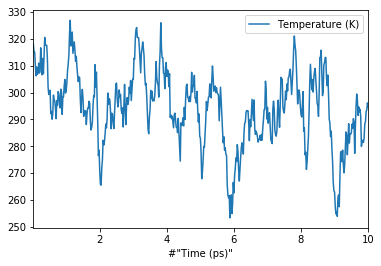

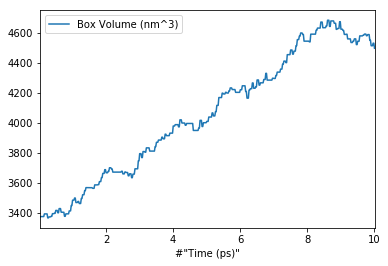

In [12]:
df = pandas.read_csv("ljscalars.csv")
df.plot(kind='line', x='#"Time (ps)"', y='Temperature (K)')
df.plot(kind='line', x='#"Time (ps)"', y='Box Volume (nm^3)')

**<mark> Exercsie </mark>**

> - Slow down the thermostat and speed up the barostat. Can you make arbitrary changes without crashing the molecular dynamics run?
>
> - Change to pressure to $10\,\textrm{bar}$ and the temperature to $50\,\textrm{K}$. Under these conditions, argon becomes a solid, see e.g. [Figure 1](https://www.nature.com/articles/srep15850/figures/1) of [10.1038/srep15850](https://doi.org/10.1038/srep15850). You will also have to change other parameters to make this work. Do you see any signs in your simulation of a phase transition?